<h1 align="center">IBM Data Science Capstone Project</h1>
<h4 align="center"><font color="#555"><i>Predicting the best location for a new restaurant in Los Angeles</i></font></h4>

## Introduction

This notebook will guide you through a theoretical business problem. The question that we are trying to answer is the following: A successful owner of multiple mid to high-end restaurants decided to open a new restaurant in Los Angeles. Having visited the city many times in recent years, he couldn’t disregard the big boom in gastronomy. He is keen on opening a new unit, which will focus on the European and Asian fusion kitchen.

Considering the price level at which the restaurant will operate, the intent is to find an optimal location in an area, where gastronomy is booming, and which is easily accessible for tourists and for wealthier local citizens as well.

### Assumptions, Business Logic

The assumption behind the analysis is that we can use unsupervised machine learning to create clusters of districts that will provide us a list of areas for consideration for the restaurant. The intent is that the restaurant to be situated close one of the gastronomical centers.

### Data

To perform this analysis, we will need the following data: 

* **Dataset** of the neighborhoods of **LA** with their **Geo-coordinates**
* **Top venues** of the neighborhoods

### Methodology

After tidying up the data, we will apply K-means machine learning technique for creating clusters of districts. We will use silhouette score for choosing the optimal number of clusters.

### Limitations

The analysis has some limitations that should be taken into account. Some limitations:

* The analysis is performed on a neighborhood level.
* When collecting venues, a 1000-meter radius is used around the center coordinates of the neighborhoods.
* The number of collected venues is limited to 100 per neighborhood.

---

## 1. Importing prerequisites

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

## 2. Exploring the dataset

Loading the dataset in `LA_NHPD_C.csv` which contains all neighborhoods in LA with their dirtricts and location coordinates.

In [2]:
LAND = pd.read_csv("../data_files/LA_NHPD_C.csv")
LAND.drop(columns=["Unnamed: 0"], inplace=True)

Taking a look at the head of it.

In [3]:
LAND.head()

NEIGHBORHOOD                DISTRICT  LATITUDE  LONGITUDE
0            Acton         Antelope Valley  34.46815 -118.19513
1  Adams-Normandie              South L.A.  34.07809 -118.30120
2     Agoura Hills  Santa Monica Mountains  34.14611 -118.77812
3       Agua Dulce        Northwest County  34.49570 -118.32621
4         Alhambra      San Gabriel Valley  34.09370 -118.12727

> **LA** has **272 neighborhoods**, so this is a real dataset.

In [4]:
LAND.shape

(272, 4)

## 3. Representing the dataset on a map

#### Use geopy library to get the latitude and longitude values of LA.

In [6]:
LA_ADRS = 'Los Angeles, California, US'
geolocator = Nominatim(user_agent="user_agent")
location = geolocator.geocode(LA_ADRS)
LA_LATI = location.latitude
LA_LONG = location.longitude
print(LA_LATI, LA_LONG)

34.0536909 -118.2427666


#### Creating a map of LA with neighborhoods superimposed on top.

In [58]:
# create map of LA using latitude and longitude values
LA_MAP = folium.Map(location=[LA_LATI, LA_LONG], zoom_start=9)

# add markers to map
for LATI, LONG, DISTRICT, NEIGHBORHOOD in zip(LAND['LATITUDE'], LAND['LONGITUDE'], LAND['DISTRICT'], LAND['NEIGHBORHOOD']):
    label = '{}, {}'.format(NEIGHBORHOOD, DISTRICT)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        (LATI, LONG),
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False
    ).add_to(LA_MAP)
    
LA_MAP

## 4. Getting all recommended nearby venues in each neighborhood in LA

Utilizing the Foursquare API to explore the neighbourhoods and segment them.

#### Storing Foursquare Credentials and `VERSION`.

In [11]:
CLIENT_ID = 'client_id'
CLIENT_SECRET = 'client_secret'
VERSION = '20180605'

#### Define `LIMIT` and `RADIUS`.

In [13]:
LIMIT = 100
RADIUS = 1000

Implementing get recommended nearby venues function.

In [14]:
from time import sleep

def getNearbyVenues(names, latitudes, longitudes):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            RADIUS,
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

        sleep(1)

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood',
                  'Neighbourhood Latitude',
                  'Neighbourhood Longitude',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [15]:
LA_VENUES = getNearbyVenues(
    names=LAND['NEIGHBORHOOD'],
    latitudes=LAND['LATITUDE'],
    longitudes=LAND['LONGITUDE']
)

Acton
Adams-Normandie
Agoura Hills
Agua Dulce
Alhambra
Alondra Park
Altadena
Angeles Crest
Arcadia
Arleta
Arlington Heights
Artesia
Athens
Atwater Village
Avalon
Avocado Heights
Azusa
Baldwin Hills/Crenshaw
Baldwin Park
Bel-Air
Bell
Bellflower
Bell Gardens
Beverly Crest
Beverly Grove
Beverly Hills
Beverlywood
Boyle Heights
Bradbury
Brentwood
Broadway-Manchester
Burbank
Calabasas
Canoga Park
Carson
Carthay
Castaic
Castaic Canyons
Central-Alameda
Century City
Cerritos
Charter Oak
Chatsworth
Chatsworth Reservoir
Chesterfield Square
Cheviot Hills
Chinatown
Citrus
Claremont
Commerce
Compton
Covina
Cudahy
Culver City
Cypress Park
Del Aire
Del Rey
Desert View Highlands
Diamond Bar
Downey
Downtown
Duarte
Eagle Rock
East Compton
East Hollywood
East La Mirada
East Los Angeles
East Pasadena
East San Gabriel
Echo Park
Elizabeth Lake
El Monte
El Segundo
El Sereno
Elysian Park
Elysian Valley
Encino
Exposition Park
Fairfax
Florence
Florence-Firestone
Gardena
Glassell Park
Glendale
Glendora
Gramercy P

Taking a little look.

In [76]:
LA_VENUES.head()

Neighbourhood  Neighbourhood Latitude  Neighbourhood Longitude  \
0         Acton                34.46815               -118.19513   
1         Acton                34.46815               -118.19513   
2         Acton                34.46815               -118.19513   
3         Acton                34.46815               -118.19513   
4         Acton                34.46815               -118.19513   

                          Venue  Venue Latitude  Venue Longitude  \
0  Acton Market & Country Store       34.468595      -118.197626   
1        Fox Hay Feed and Grain       34.469565      -118.195481   
2                  Acton Market       34.467628      -118.195892   
3    TSW Social Media Marketing       34.470898      -118.192307   
4               specialty truss       34.470898      -118.192307   

               Venue Category  
0               Grocery Store  
1                   Pet Store  
2               Grocery Store  
3                      Market  
4  Construction & Landscaping

Counting the returned venues per neighborhood.

In [18]:
LA_VENUES.groupby('Neighbourhood').count()

Neighbourhood Latitude  \
Neighbourhood                                                   
Acton                                                       8   
Adams-Normandie                                            83   
Agoura Hills                                               17   
Agua Dulce                                                 11   
Alhambra                                                   73   
Alondra Park                                               40   
Altadena                                                   29   
Arcadia                                                    52   
Arleta                                                     13   
Arlington Heights                                          33   
Artesia                                                   100   
Athens                                                     19   
Atwater Village                                           100   
Avalon                                                     71   
Avocado Heights                                            19   
Azusa                                                      36   
Baldwin Hills/Crenshaw                                     81   
Baldwin Park                                               46   
Bel-Air                                                     8   
Bell                                                       40   
Bell Gardens                                               21   
Bellflower                                                 62   
Beverly Crest                                               6   
Beverly Grove                                               6   
Beverly Hills                                             100   
Beverlywood                                                50   
Boyle Heights                                              76   
Bradbury                                                   29   
Brentwood                                                  35   
Broadway-Manchester                                        17   
Burbank                                                   100   
Calabasas                                                  70   
Canoga Park                                                77   
Carson                                                     50   
Carthay                                                     6   
Castaic                                                    32   
Central-Alameda                                            16   
Century City                                              100   
Cerritos                                                   62   
Charter Oak                                                15   
Chatsworth                                                 34   
Chatsworth Reservoir                                        4   
Chesterfield Square                                        37   
Cheviot Hills                                              51   
Chinatown                                                  73   
Citrus                                                     14   
Claremont                                                  74   
Commerce                                                   76   
Compton                                                    27   
Covina                                                     57   
Cudahy                                                     13   
Culver City                                                89   
Cypress Park                                               15   
Del Aire                                                   27   
Del Rey                                                    45   
Desert View Highlands                                      43   
Diamond Bar                                                12   
Downey                                                    100   
Downtown                                                  100   
Duarte                                                     37   
Eagle Roc

## 5. Analyze each neighborhood

In [19]:
# one hot encoding
LA_OH = pd.get_dummies(LA_VENUES[['Venue Category']], prefix="", prefix_sep="")

# add Neighbourhood column back to dataframe
LA_OH['Neighbourhood'] = LA_VENUES['Neighbourhood']

# move Neighbourhood column to the first column
fixed_columns = [LA_OH.columns[-1]] + list(LA_OH.columns[:-1])
LA_OH = LA_OH[fixed_columns]

LA_OH.head()

Neighbourhood  ATM  Accessories Store  African Restaurant  Airport  \
0         Acton    0                  0                   0        0   
1         Acton    0                  0                   0        0   
2         Acton    0                  0                   0        0   
3         Acton    0                  0                   0        0   
4         Acton    0                  0                   0        0   

   Airport Gate  Airport Service  Airport Terminal  American Restaurant  \
0             0                0                 0                    0   
1             0                0                 0                    0   
2             0                0                 0                    0   
3             0                0                 0                    0   
4             0                0                 0                    0   

   Amphitheater  Andhra Restaurant  Antique Shop  Aquarium  Arcade  \
0             0                  0             0         0       0   
1             0                  0             0         0       0   
2             0                  0             0         0       0   
3             0                  0             0         0       0   
4             0                  0             0         0       0   

   Argentinian Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
0                       0            0           0                    0   
1                       0            0           0                    0   
2                       0            0           0                    0   
3                       0            0           0                    0   
4                       0            0           0                    0   

   Arts & Entertainment  Asian Restaurant  Astrologer  Athletics & Sports  \
0                     0                 0           0                   0   
1                     0                 0           0                   0   
2                     0                 0           0                   0   
3                     0                 0           0                   0   
4                     0                 0           0                   0   

   Australian Restaurant  Auto Dealership  Auto Garage  Auto Workshop  \
0                      0                0            0              0   
1                      0                0            0              0   
2                      0                0            0              0   
3                      0                0            0              0   
4                      0                0            0              0   

   Automotive Shop  BBQ Joint  Baby Store  Bagel Shop  Bakery  Bank  Bar  \
0                0          0           0           0       0     0    0   
1                0          0           0           0       0     0    0   
2                0          0           0           0       0     0    0   
3                0          0           0           0       0     0    0   
4                0          0           0           0       0     0    0   

   Baseball Field  Baseball Stadium  Basketball Court  Bay  Beach  \
0               0                 0                 0    0      0   
1               0                 0                 0    0      0   
2               0                 0                 0    0      0   
3               0                 0                 0    0      0   
4               0                 0                 0    0      0   

   Bed & Breakfast  Beer Bar  Beer Garden  Beer Store  Big Box Store  \
0                0         0            0           0              0   
1                0         0            0           0              0   
2                0         0            0           0              0   
3                0         0            0           0              0   
4                0         0            0           0              0   

   Bike Rental / Bike Share  Bike Trail

####  Grouping rows by neighborhood and by taking the mean of the frequency of occurrence of each category.

In [20]:
LA_G = LA_OH.groupby('Neighbourhood').mean().reset_index()
LA_G

Neighbourhood       ATM  Accessories Store  \
0                                    Acton  0.000000           0.000000   
1                          Adams-Normandie  0.000000           0.000000   
2                             Agoura Hills  0.000000           0.000000   
3                               Agua Dulce  0.000000           0.000000   
4                                 Alhambra  0.000000           0.000000   
5                             Alondra Park  0.000000           0.000000   
6                                 Altadena  0.000000           0.000000   
7                                  Arcadia  0.000000           0.000000   
8                                   Arleta  0.000000           0.000000   
9                        Arlington Heights  0.000000           0.000000   
10                                 Artesia  0.000000           0.000000   
11                                  Athens  0.000000           0.000000   
12                         Atwater Village  0.000000           0.000000   
13                                  Avalon  0.014085           0.000000   
14                         Avocado Heights  0.000000           0.000000   
15                                   Azusa  0.000000           0.000000   
16                  Baldwin Hills/Crenshaw  0.000000           0.012346   
17                            Baldwin Park  0.000000           0.000000   
18                                 Bel-Air  0.000000           0.000000   
19                                    Bell  0.025000           0.000000   
20                            Bell Gardens  0.047619           0.000000   
21                              Bellflower  0.000000           0.000000   
22                           Beverly Crest  0.000000           0.000000   
23                           Beverly Grove  0.000000           0.000000   
24                           Beverly Hills  0.000000           0.010000   
25                             Beverlywood  0.000000           0.000000   
26                           Boyle Heights  0.013158           0.000000   
27                                Bradbury  0.000000           0.000000   
28                               Brentwood  0.000000           0.000000   
29                     Broadway-Manchester  0.058824           0.000000   
30                                 Burbank  0.000000           0.000000   
31                               Calabasas  0.028571           0.000000   
32                             Canoga Park  0.000000           0.000000   
33                                  Carson  0.000000           0.040000   
34                                 Carthay  0.000000           0.000000   
35                                 Castaic  0.000000           0.000000   
36                         Central-Alameda  0.000000           0.000000   
37                            Century City  0.000000           0.000000   
38                                Cerritos  0.000000           0.000000   
39                             Charter Oak  0.000000           0.000000   
40                              Chatsworth  0.000000           0.000000   
41                    Chatsworth Reservoir  0.000000           0.000000   
42                     Chesterfield Square  0.000000           0.000000   
43                           Cheviot Hills  0.000000           0.000000   
44                               Chinatown  0.000000           0.000000   
45                                  Citrus  0.000000           0.000000   
46                               Claremont  0.000000           0.000000   
47                                Commerce  0.000000           0.065789   
48                                 Compton  0.000000           0.000000   
49                                  Covina  0.000000           0.000000   
50                                  Cudahy  0.076923           0.000000   
51                             Culver City  0.000000           0.000000   
52                            Cypress Park  0.000000  

Confirming the new size.

In [21]:
LA_G.shape

(268, 454)

Implementing a function to sort the venues in descending order.

In [22]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### Creating the new dataframe and display the top 10 venues for each neighbourhood.

In [33]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = LA_G['Neighbourhood']

for ind in np.arange(LA_G.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(LA_G.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

Neighbourhood 1st Most Common Venue 2nd Most Common Venue  \
0            Acton                  Park         Grocery Store   
1  Adams-Normandie       Thai Restaurant           Coffee Shop   
2     Agoura Hills                  Park      Ramen Restaurant   
3       Agua Dulce                Bakery                  Park   
4         Alhambra        Ice Cream Shop                  Bank   

  3rd Most Common Venue       4th Most Common Venue 5th Most Common Venue  \
0       Nature Preserve  Construction & Landscaping                Market   
1     Korean Restaurant                         Bar    Seafood Restaurant   
2  Fast Food Restaurant                      Casino              Car Wash   
3         Grocery Store                Home Service    Mexican Restaurant   
4                Bakery             Bubble Tea Shop                   Gym   

     6th Most Common Venue         7th Most Common Venue  \
0                Pet Store                 Deli / Bodega   
1              Pizza Place                Sandwich Place   
2  Health & Beauty Service  General College & University   
3                Gift Shop                          Café   
4                     Park            Seafood Restaurant   

       8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0           Department Store               Exhibit             Eye Doctor  
1  Latin American Restaurant                Bakery          Grocery Store  
2            Laundry Service           Pizza Place              Gastropub  
3                Pizza Place      Business Service             Restaurant  
4       Fast Food Restaurant            Shoe Store                   Café

## 6. Using machine learning for clustering neighborhoods

For clustering, K-means method will be applied. To be able to select the optimal number of clusters, the silhouette score will be used.

First, let's find out the optimal number of clusters. For that, we will create a graph of the silhouette scores.

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot(x, y, xlabel, ylabel):
    plt.figure(figsize=(20,10))
    plt.plot(np.arange(2, x), y, 'o-')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(2, x))
    plt.show()

In [69]:
max_range = 8

LA_GC = LA_G.drop('Neighbourhood', 1)

from sklearn.metrics import silhouette_samples, silhouette_score

indices = []
scores = []

for kclusters in range(2, max_range) :
    
    # Run k-means clustering
    kmc = LA_GC
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(kmc)
    
    # Gets the score for the clustering operation performed
    score = silhouette_score(kmc, kmeans)
    
    # Appending the index and score to the respective lists
    indices.append(kclusters)
    scores.append(score)

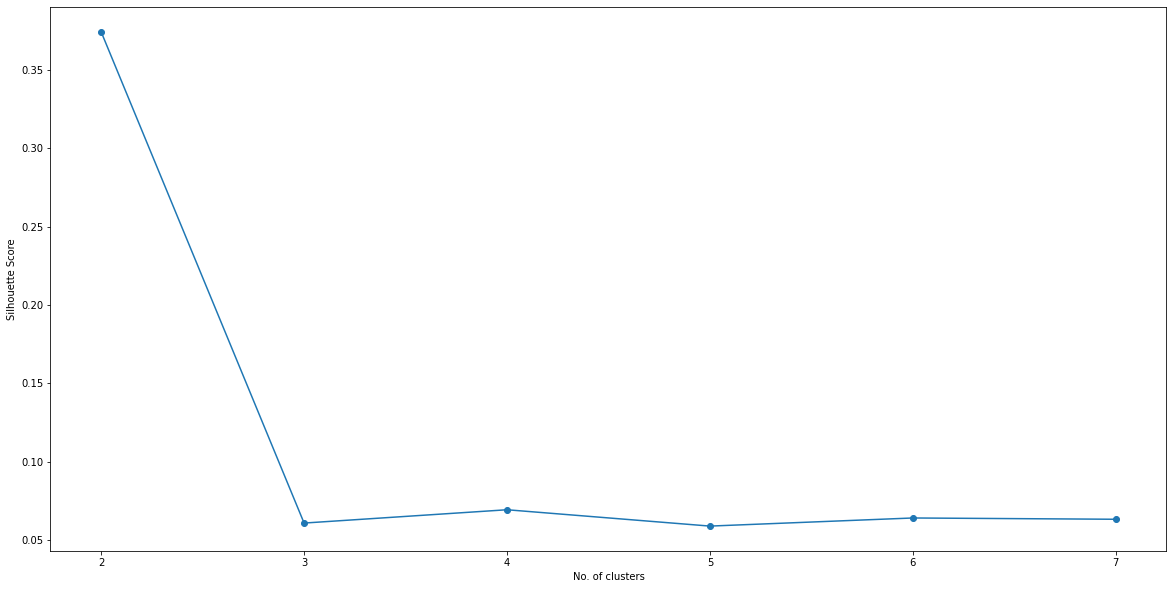

In [70]:
plot(max_range, scores, "No. of clusters", "Silhouette Score")

> Based on this graph, we can see that the optimal number of clusters is **2**.

Now, let's run the K-means clustering with the optimal number of clusters, which is 2.

In [71]:
# run k-means clustering
kmeans = KMeans(n_clusters=2, random_state=0).fit(LA_GC)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

Creating a new dataframe that includes the cluster as well as the top 10 venues for each neighbourhood.

In [72]:
# add clustering labels
neighbourhoods_venues_sorted.drop(columns=['Cluster Labels'], inplace=True)
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

LAND_M = LAND

LAND_M = LAND_M.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='NEIGHBORHOOD')

LAND_M.head() # check the last columns!

NEIGHBORHOOD                DISTRICT  LATITUDE  LONGITUDE  \
0            Acton         Antelope Valley  34.46815 -118.19513   
1  Adams-Normandie              South L.A.  34.07809 -118.30120   
2     Agoura Hills  Santa Monica Mountains  34.14611 -118.77812   
3       Agua Dulce        Northwest County  34.49570 -118.32621   
4         Alhambra      San Gabriel Valley  34.09370 -118.12727   

   Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
0             1.0                  Park         Grocery Store   
1             0.0       Thai Restaurant           Coffee Shop   
2             0.0                  Park      Ramen Restaurant   
3             0.0                Bakery                  Park   
4             0.0        Ice Cream Shop                  Bank   

  3rd Most Common Venue       4th Most Common Venue 5th Most Common Venue  \
0       Nature Preserve  Construction & Landscaping                Market   
1     Korean Restaurant                         Bar    Seafood Restaurant   
2  Fast Food Restaurant                      Casino              Car Wash   
3         Grocery Store                Home Service    Mexican Restaurant   
4                Bakery             Bubble Tea Shop                   Gym   

     6th Most Common Venue         7th Most Common Venue  \
0                Pet Store                 Deli / Bodega   
1              Pizza Place                Sandwich Place   
2  Health & Beauty Service  General College & University   
3                Gift Shop                          Café   
4                     Park            Seafood Restaurant   

       8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0           Department Store               Exhibit             Eye Doctor  
1  Latin American Restaurant                Bakery          Grocery Store  
2            Laundry Service           Pizza Place              Gastropub  
3                Pizza Place      Business Service             Restaurant  
4       Fast Food Restaurant            Shoe Store                   Café

#### Visualizing the resulting clusters.

In [73]:
# create map
map_clusters = folium.Map(location=[LA_LATI, LA_LONG], zoom_start=9)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(LAND_M['LATITUDE'], LAND_M['LONGITUDE'], LAND_M['NEIGHBORHOOD'], LAND_M['Cluster Labels']):
    cluster = int(0 if np.isnan(cluster) else cluster)
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        (lat, lon),
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 7. Examining Clusters

#### Cluster 1

In [74]:
LAND_M.loc[LAND_M['Cluster Labels'] == 0, LAND_M.columns[[1] + list(range(5, LAND_M.shape[1]))]]

DISTRICT      1st Most Common Venue  \
1                South L.A.            Thai Restaurant   
2    Santa Monica Mountains                       Park   
3          Northwest County                     Bakery   
4        San Gabriel Valley             Ice Cream Shop   
5                 South Bay       Fast Food Restaurant   
6                  Verdugos              Grocery Store   
8        San Gabriel Valley                  Racetrack   
9       San Fernando Valley         Mexican Restaurant   
10             Central L.A.  Latin American Restaurant   
11                Southeast          Indian Restaurant   
12               South L.A.       Fast Food Restaurant   
13           Northeast L.A.                Coffee Shop   
14                   Harbor              Boat or Ferry   
15       San Gabriel Valley         Mexican Restaurant   
16       San Gabriel Valley         Mexican Restaurant   
17               South L.A.       Fast Food Restaurant   
18       San Gabriel Valley                Pizza Place   
19                 Westside                       Café   
20                Southeast         Mexican Restaurant   
21                Southeast         Mexican Restaurant   
22                Southeast               Burger Joint   
24             Central L.A.              Historic Site   
25                 Westside                   Boutique   
26                 Westside                       Park   
27                 Eastside         Mexican Restaurant   
28       San Gabriel Valley         Mexican Restaurant   
29                 Westside         Italian Restaurant   
30               South L.A.                       Food   
31      San Fernando Valley             Clothing Store   
32   Santa Monica Mountains                Coffee Shop   
33      San Fernando Valley         Mexican Restaurant   
34                   Harbor       Fast Food Restaurant   
36         Northwest County         Mexican Restaurant   
39                 Westside                Coffee Shop   
40                Southeast          Korean Restaurant   
41       San Gabriel Valley          Food & Drink Shop   
42      San Fernando Valley                Pizza Place   
44               South L.A.         Chinese Restaurant   
45                 Westside                Pizza Place   
46             Central L.A.         Chinese Restaurant   
48            Pomona Valley                Coffee Shop   
49                Southeast             Clothing Store   
50                Southeast       Fast Food Restaurant   
51       San Gabriel Valley                Pizza Place   
52                Southeast       Fast Food Restaurant   
53                 Westside                Coffee Shop   
54           Northeast L.A.         Mexican Restaurant   
55                South Bay                        Gym   
56                 Westside         Mexican Restaurant   
57          Antelope Valley         Mexican Restaurant   
58       San Gabriel Valley                Coffee Shop   
59                Southeast             Clothing Store   
60             Central L.A.           Sushi Restaurant   
61       San Gabriel Valley       Fast Food Restaurant   
62           Northeast L.A.         Mexican Restaurant   
63                Southeast         Mexican Restaurant   
64             Central L.A.                Pizza Place   
65                Southeast                Pizza Place   
66                 Eastside         Mexican Restaurant   
67       San Gabriel Valley                Coffee Shop   
68       San Gabriel Valley              Grocery Store   
69             Central L.A.                       Café   
70         Northwest County                       Lake   
71       San Gabriel Valley       Fast Food Restaurant   
72                South Bay                Pizza Place   
73                 Eastside         Mexican Restaurant   
75             Central L.A.       Fast Food Restaurant   
76      San Fernando Valley                     Bakery   
77               

#### Cluster 2

In [75]:
LAND_M.loc[LAND_M['Cluster Labels'] == 1, LAND_M.columns[[1] + list(range(5, LAND_M.shape[1]))]]

DISTRICT       1st Most Common Venue 2nd Most Common Venue  \
0           Antelope Valley                        Park         Grocery Store   
23                 Westside                        Park        Clothing Store   
35             Central L.A.                        Park            Food Truck   
38               South L.A.                        Food                  Park   
43      San Fernando Valley                       Trail                  Park   
47       San Gabriel Valley                        Park                Bakery   
74             Central L.A.                        Park        Scenic Lookout   
88         Northwest County                        Food            Playground   
89             Central L.A.                       Trail        Scenic Lookout   
97         Northwest County  Construction & Landscaping               Dog Run   
106            Central L.A.                       Trail        Scenic Lookout   
120         Antelope Valley             Thai Restaurant     Electronics Store   
121     San Fernando Valley                         Zoo   American Restaurant   
151          Northeast L.A.                        Park        History Museum   
153          Northeast L.A.                       Trail                  Park   
161      San Gabriel Valley                        Park                   Gym   
187               South Bay                        Park                Garden   
213      San Gabriel Valley          Mexican Restaurant                  Park   
219         Antelope Valley  Construction & Landscaping         Moving Target   
229  Santa Monica Mountains                       Trail            Food Truck   
230        Northwest County                       Trail  Gym / Fitness Center   
236        Northwest County                        Food                  Park   
241              South L.A.                Liquor Store                  Food   
267              South L.A.                Home Service     Convenience Store   

    3rd Most Common Venue       4th Most Common Venue  \
0         Nature Preserve  Construction & Landscaping   
23   Other Great Outdoors                         Zoo   
35             Skate Park              Baseball Field   
38             Taco Place                Burger Joint   
43           Gourmet Shop            Business Service   
47           Home Service                  Donut Shop   
74             Food Truck          Mexican Restaurant   
88           Home Service                         Zoo   
89            Planetarium                        Café   
97                  Trail                         Zoo   
106              Mountain                        Park   
120                  Park                        Lake   
121                  Farm                        Park   
151                 Trail               Grocery Store   
153        History Museum            Recording Studio   
161                 Hotel                  Hotel Pool   
187             Speakeasy                   BBQ Joint   
213          Home Service            Storage Facility   
219          Home Service                         Zoo   
229                Market                         Gym   
230            Playground                        Park   
236          Home Service                         Zoo   
241                  Park           Convenience Store   
267                  Park                  Restaurant   

          5th Most Common Venue       6th Most Common Venue  \
0                        Market                   Pet Store   
23                  Film Studio                 Event Space   
35                        Trail           Food & Drink Shop   
38                     Bus Line  Construction & Landscaping   
43                  Film Studio                 Event Space   
47                  Gas Station                 Coffee Shop   
74                        Trail                  Playground   
88                  Film Studio                 Event Space   


## Conclusion

### Understanding the Clusters

By looking at the cluster data, we can see that cluster 1 is the one that we are the most interested in.

* **Cluster 1** is the biggest cluster, but this is where we see lots of gastronomy related venues (coffee shop, pizza place, American Restaurant, bar, Mexican Restaurant, etc..).

* **Cluster 2** is neighborhoods where public travel rated at top, but behind that parks, playgrounds are also present. These are mainly areas with family houses where people live, but not really the vibrant, lively part of the city.

Based on that, we can advise the restaurant owner to consider the neighborhood from this cluster as the potential location for the new restaurant.